<a href="https://colab.research.google.com/github/deepakkollala/CE888_Labs/blob/main/lab8/lab8__transferlearning_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sagihaider/CE888_2021.git

Cloning into 'CE888_2021'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 381 (delta 120), reused 30 (delta 17), pack-reused 190
Receiving objects: 100% (381/381), 20.57 MiB | 50.99 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [2]:


# Unzip training data
from zipfile import ZipFile
file_name = "/content/CE888_2021/Lab_8/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
base_dir = './'

In [4]:
import os

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [5]:
pth = 'test'
os.mkdir('/content/'+pth+'/Humans')
os.mkdir('/content/'+pth+'/cats')
os.mkdir('/content/'+pth+'/dogs')
os.mkdir('/content/'+pth+'/horses')

pth = 'train'
os.mkdir('/content/'+pth+'/Humans')
os.mkdir('/content/'+pth+'/cats')
os.mkdir('/content/'+pth+'/dogs')
os.mkdir('/content/'+pth+'/horses')


In [6]:

import pandas as pd
import shutil

def split_data(cls):
  flname = []
  fullpath = []
  strpath = './data/' + cls
  for filename in os.listdir(strpath):
      if filename.endswith("jpg"): 
        flname.append(filename)
        fullpath.append(strpath + '/' + filename)

  df = pd.DataFrame({'filename':flname, 'fullpath':fullpath })
  n_split = .7
  tot = len(fullpath)
  train_tot = round(len(fullpath) * n_split)
  test_tot = round(len(fullpath) * (1-n_split))

  train_df = df.iloc[:train_tot,:]
  test_df = df.iloc[train_tot:,:]

  for idx, row in train_df.iterrows():
    src = row['fullpath']
    dst = './train/' + cls + '/' + row['filename']
    print('train', src,dst)
    shutil.copyfile(src, dst)

  for idx, row in test_df.iterrows():
    src = row['fullpath']
    dst = './test/' + cls + '/' + row['filename']
    print('train', src,dst)
    shutil.copyfile(src, dst)

In [7]:
split_data('Humans')
split_data('cats')
split_data('dogs')
split_data('horses')


train ./data/Humans/rider-128.jpg ./train/Humans/rider-128.jpg
train ./data/Humans/rider-114.jpg ./train/Humans/rider-114.jpg
train ./data/Humans/rider-88.jpg ./train/Humans/rider-88.jpg
train ./data/Humans/rider-146.jpg ./train/Humans/rider-146.jpg
train ./data/Humans/rider-182.jpg ./train/Humans/rider-182.jpg
train ./data/Humans/rider-99.jpg ./train/Humans/rider-99.jpg
train ./data/Humans/rider-1.jpg ./train/Humans/rider-1.jpg
train ./data/Humans/rider-186.jpg ./train/Humans/rider-186.jpg
train ./data/Humans/rider-31.jpg ./train/Humans/rider-31.jpg
train ./data/Humans/rider-126.jpg ./train/Humans/rider-126.jpg
train ./data/Humans/rider-29.jpg ./train/Humans/rider-29.jpg
train ./data/Humans/rider-55.jpg ./train/Humans/rider-55.jpg
train ./data/Humans/rider-67.jpg ./train/Humans/rider-67.jpg
train ./data/Humans/rider-173.jpg ./train/Humans/rider-173.jpg
train ./data/Humans/rider-33.jpg ./train/Humans/rider-33.jpg
train ./data/Humans/rider-57.jpg ./train/Humans/rider-57.jpg
train ./data

In [8]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import cv2
import numpy as np
from random import shuffle

In [9]:
def label_img(img):
    #print('img', img)
    word_label = img.split('.')[0]
    #print('word_label', word_label)
    if word_label == 'Humans': return 0
    elif word_label == 'cats': return 1
    elif word_label == 'dogs': return 2
    elif word_label == 'horses': return 3
    

In [10]:
IMG_SIZE = 150
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for f in os.listdir(datapath):
        label = label_img(f)
        #print(label)
        path = os.path.join(datapath, f)

        for img in os.listdir(path):
          ipath = os.path.join(path, img)
          #print(ipath)
          image = cv2.resize(cv2.imread(ipath), (IMG_SIZE, IMG_SIZE))
          image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

          X.append(np.array(image))
          y.append(label)

    return np.array(X), np.array(y)

In [11]:
train_dir = '/content/train'
validation_dir = '/content/test'
test_dir= '/content/test'

In [12]:
from keras.utils import to_categorical


train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)


train_y = to_categorical(train_y, 4)
val_y = to_categorical(val_y, 4)
test_y = to_categorical(test_y, 4)

In [13]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size = (150, 150),
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test',
        target_size = (150, 150),
        batch_size=32,
        class_mode='categorical')

Found 564 images belonging to 4 classes.
Found 244 images belonging to 4 classes.


In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop


base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

87916544/87910968 [==============================] - 1s 0us/step


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='inception.h5', save_best_only=True),
]

In [16]:
history = model.fit(train_X, train_y,
                               batch_size=10,
                               epochs=10, 
                               validation_data=(val_X, val_y),
                               callbacks=my_callbacks)

Epoch 1/10
57/57 [==============================] - 40s 71ms/step - loss: 5.4420 - acc: 0.6328 - val_loss: 1.8615 - val_acc: 0.8361
Epoch 2/10
57/57 [==============================] - 2s 35ms/step - loss: 0.8531 - acc: 0.9116 - val_loss: 0.5815 - val_acc: 0.9221
Epoch 3/10
57/57 [==============================] - 2s 36ms/step - loss: 0.4077 - acc: 0.9393 - val_loss: 0.6007 - val_acc: 0.9344
Epoch 4/10
57/57 [==============================] - 2s 35ms/step - loss: 0.4597 - acc: 0.9429 - val_loss: 0.4479 - val_acc: 0.9631
Epoch 5/10
57/57 [==============================] - 2s 36ms/step - loss: 0.3386 - acc: 0.9618 - val_loss: 0.9208 - val_acc: 0.9344
Epoch 6/10
57/57 [==============================] - 2s 35ms/step - loss: 0.2218 - acc: 0.9739 - val_loss: 0.7444 - val_acc: 0.9426
Epoch 7/10
57/57 [==============================] - 2s 35ms/step - loss: 0.1170 - acc: 0.9742 - val_loss: 1.1096 - val_acc: 0.9098
Epoch 8/10
57/57 [==============================] - 2s 35ms/step - loss: 0.1396 - 

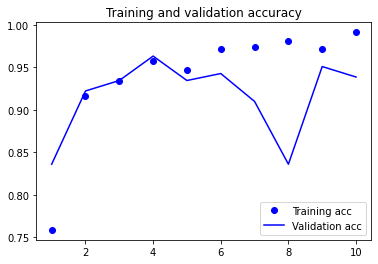

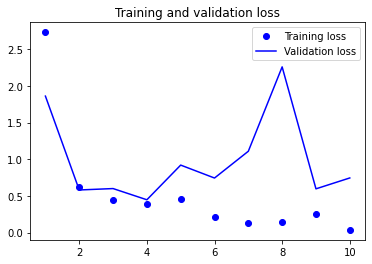

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred)

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9929078221321106
Val Accuracy:	 0.9344262480735779
Test Accuracy:	 0.9344262295081968
Precision:	 [0.98275862 0.96491228 0.90163934 0.89705882]
Recall:		 [0.93442623 0.90163934 0.90163934 1.        ]
F1 Score:	 [0.95798319 0.93220339 0.90163934 0.94573643]
AUC:		 0.9562841530054644
